+----------+----------+----------+----------+
|product_id|year_month|avg_rating|      date|
+----------+----------+----------+----------+
|0030586232|   2004-06|       5.0|2004-06-01|
|0060174056|   1998-10|      3.33|1998-10-01|
|0060174056|   1998-11|       4.5|1998-11-01|
|0060174056|   1998-12|       5.0|1998-12-01|
|0060174056|   1999-01|       4.0|1999-01-01|
+----------+----------+----------+----------+
only showing top 5 rows

monthly average:
+----------+------------------+
|      date|monthly_avg_rating|
+----------+------------------+
|1995-09-01|               5.0|
|1996-05-01|               5.0|
|1996-06-01|               5.0|
|1996-07-01|               5.0|
|1996-08-01| 4.833333333333333|
|1996-11-01|               4.0|
|1996-12-01|               5.0|
|1997-01-01| 4.666666666666667|
|1997-02-01|               5.0|
|1997-03-01| 4.333333333333333|
|1997-04-01|              4.75|
|1997-05-01|               4.4|
|1997-06-01|               5.0|
|1997-07-01|               5.0|


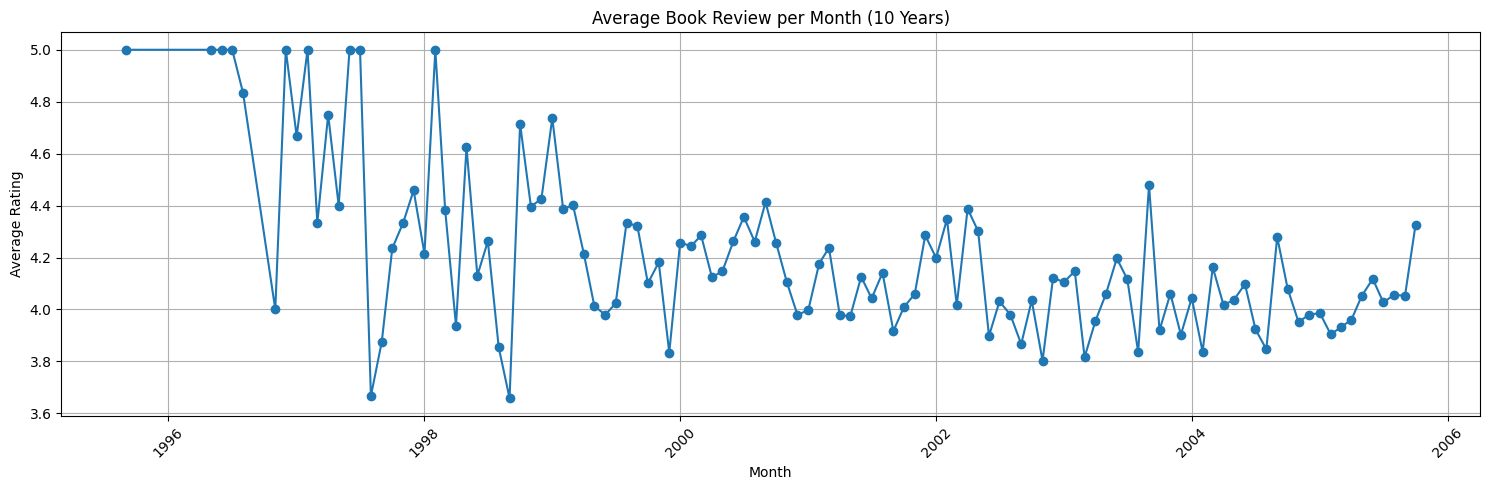

In [18]:
import findspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date, concat, lit, avg
import matplotlib.pyplot as plt
from pymongo import MongoClient
from datetime import datetime

findspark.init()
spark = SparkSession.builder \
    .appName("BooksAvgPerMonth") \
    .getOrCreate()


hdfs_path = "hdfs://localhost:9000/usr/ubuntu/output/books_avg/part-*"

df = spark.read.option("sep", "\t") \
    .option("header", False) \
    .csv(hdfs_path) \
    .toDF("product_id", "year_month", "avg_rating")



df = df.withColumn("avg_rating", col("avg_rating").cast("float"))
df = df.withColumn("date", to_date(concat(col("year_month").cast("string"), lit("-01")), "yyyy-MM-dd"))
df = df.filter((year(col("date")) >= 1995) & (year(col("date")) <= 2006))
df.show(5)


monthly_avg_df = df.groupBy("date").agg(avg("avg_rating").alias("monthly_avg_rating"))
monthly_avg_df = monthly_avg_df.orderBy("date")
print("monthly average:")
monthly_avg_df.show(20)


def save_to_mongo(df, database="amazon_reviews", collection_name="global_trend", batch_size=1000):
    client = MongoClient("mongodb://localhost:27017/")
    db = client[database]
    collection = db[collection_name]
    collection.delete_many({}) 
    batch = []
    for row in df.toLocalIterator():
        row_dict = row.asDict()
        # Converti date in datetime
        if "date" in row_dict and isinstance(row_dict["date"], (str, datetime)):
            if isinstance(row_dict["date"], str):
                row_dict["date"] = datetime.strptime(row_dict["date"], "%Y-%m-%d")
        batch.append(row_dict)
        if len(batch) == batch_size:
            collection.insert_many(batch)
            batch = []
    if batch:
        collection.insert_many(batch)

    #print(f"saved on mongoDB")



pandas_df = monthly_avg_df.toPandas()
plt.figure(figsize=(15,5))
plt.plot(pandas_df["date"], pandas_df["monthly_avg_rating"], marker="o")
plt.title("Average Book Review per Month (10 Years)")
plt.xlabel("Month")
plt.ylabel("Average Rating")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
